In [32]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [33]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [34]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

In [35]:
!mkdir -p {HOME}/weights
!mkdir -p {HOME}/data
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [36]:
import torch

print(f"Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"Cached:    {torch.cuda.memory_reserved() / 1e9:.2f} GB")
# torch.cuda.empty_cache()

Allocated: 2.93 GB
Cached:    6.93 GB


In [37]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [38]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [39]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [40]:
mask_generator = SamAutomaticMaskGenerator(sam,
    points_per_side=20,  # Manage the number of masks considered, less is less
    pred_iou_thresh=0.80  # Increase the minimum predicted IoU for masks, more is less
)

In [311]:
import os

IMAGE_NAME = "Aziz.jpg"
# IMAGE_NAME = "210_jpg.rf.f86a0e871acba9eb6f90fcfd44fe4590.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

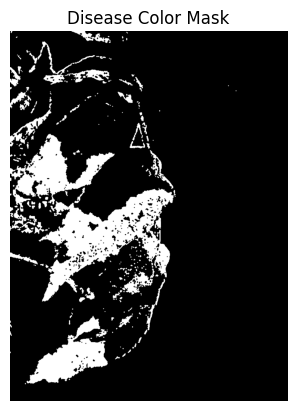

In [312]:
import cv2
import numpy as np

max_side = 1024
img = cv2.imread(IMAGE_PATH)
h, w = img.shape[:2]

# ---------- optional down‑scaling ----------
scale = min(1.0, max_side / float(max(h, w)))
if scale < 1.0:
    img_small = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
else:
    img_small = img.copy()

hsv = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)

# ---------- leaf localisation ----------
leaf_mask = cv2.inRange(hsv, (35, 40, 40), (85, 255, 255))

# build ROI that covers whole leaf
leaf_roi = cv2.dilate(leaf_mask, None, iterations=3)

# ---------- colour masks ----------
white_mask  = cv2.bitwise_and(cv2.inRange(hsv, (0, 0, 180), (180,  60, 255)), leaf_roi)
rot_mask    = cv2.bitwise_and(cv2.inRange(hsv, (5,10,20),    (60,120,100)),  leaf_roi)
yellow_mask = cv2.inRange(hsv, (23, 50, 10), (27, 255, 255))
brown_mask  = cv2.inRange(hsv, (10,100,10), (20, 255, 200))

disease_mask = white_mask | rot_mask | yellow_mask | brown_mask

# ---------- morphology ----------
kh, kw = [max(3, int(round(min(img_small.shape[:2]) * 0.003))) | 1]*2  # odd size
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kh, kw))
disease_mask = cv2.morphologyEx(disease_mask, cv2.MORPH_CLOSE, kernel)
disease_mask = cv2.morphologyEx(disease_mask, cv2.MORPH_OPEN,  kernel)

# Optional: show the disease_mask using matplotlib
import matplotlib.pyplot as plt
plt.imshow(disease_mask, cmap='gray')
plt.title("Disease Color Mask")
plt.axis("off")
plt.show()


In [313]:
# Make sure CLIP is available (silent re‑install if needed)
try:
    import clip
except ModuleNotFoundError:
    !pip -q install git+https://github.com/openai/CLIP.git
    import clip

Single drop in cell for the rest of logic to be divided


In [314]:
import os, cv2, torch, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torchvision.ops import box_iou

# ─── 1. CONFIG  ─────────────────────────────────────────────
OUT_DIR        = Path("cropped_segments_final")  # where PNG crops are saved
MIN_AREA       = 1_024        # px²; skip postage‑stamp segments
MAX_AREA       = 300_000      # = 547 × 547 px²
PADDING        = 0.05         # ⬅️  smaller padding → fewer overlaps
UPSCALE_TO     = 320          # ensure min crop size before CLIP
IOU_THRESHOLD  = 0.7         # ⬅️  keep boxes separate unless IoU ≥ 0.25
CLIP_THRES     = 0.1         # cosine‑sim threshold for CLIP keep
TOP_K_VIZ      = 6            # thumbs per class to display
OUT_DIR.mkdir(exist_ok=True, parents=True)

In [315]:
# ─── 2. PROMPT BANK & CLIP SET‑UP  ─────────────
prompt_bank = {
    "Rot": [
        "dark brown rotting leaf tissue",
        "rotting lesion on plant leaf"
    ],
    "Spot": [
        "small circular spots on green leaf",
        "leaf spot pattern disease"
    ],
    "Burn": [
        "scorched leaf margin burn",
        "sun burn on leaf edges"
    ],
    "Powdery Mildew": [
        "white powdery mildew patches",
        "powdery fungal growth on leaf"
    ],
    "Nutrient Deficiency": [
        "leaf veins remain green while yellowing occurs",
        "green leaf with chlorosis turning yellow"
    ],
}
flat_prompts, prompt_class = [], []
for cls, plist in prompt_bank.items():
    for p in plist:
        flat_prompts.append(p)
        prompt_class.append(cls)

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)
text_tokens = clip.tokenize(flat_prompts).to(device)
with torch.no_grad():
    text_feats = clip_model.encode_text(text_tokens)
    text_feats /= text_feats.norm(dim=-1, keepdim=True)   # unit‑norm

In [316]:
# ─── 3. GUIDE SAM WITH disease_mask ───────────
# --- make disease_mask FULL resolution before any geometry work ---
image_rgb = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)

if disease_mask.shape[:2] != image_rgb.shape[:2]:      # (H,W) mismatch?
    disease_mask = cv2.resize(
        disease_mask,
        (image_rgb.shape[1], image_rgb.shape[0]),       # (W,H) order
        interpolation=cv2.INTER_NEAREST)                # keep binary

ys, xs = np.where(disease_mask)
bbox = np.array([[xs.min(), ys.min(), xs.max(), ys.max()]], dtype=np.float32)  # (1,4)
sam_result = mask_generator.generate(image_rgb)

filtered_sam_result = []
for res in sam_result:
    mask = res["segmentation"].astype("uint8")
    inter = np.count_nonzero(mask & (disease_mask > 0))
    if inter > 0.25 * np.count_nonzero(mask):
        filtered_sam_result.append(res)               # keep only good masks

print("From", len(sam_result), "masks,", len(filtered_sam_result), "kept")

From 32 masks, 15 kept


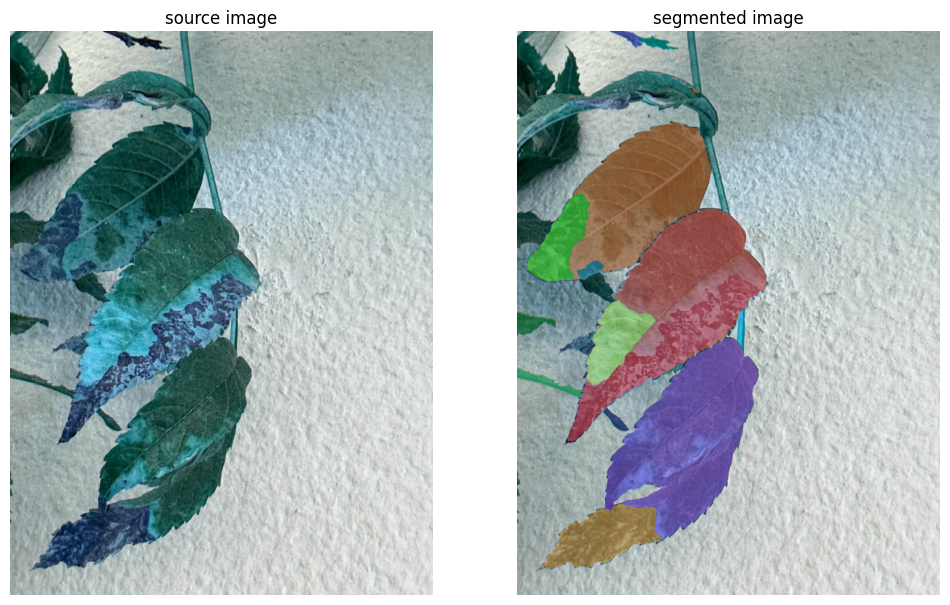

In [317]:
# ─── 4. BUILD THE DETECTIONS  ─────────────────────────
import supervision as sv
detections = sv.Detections.from_sam(sam_result=filtered_sam_result)

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
annotated = mask_annotator.annotate(scene=image_rgb.copy(),
                                    detections=detections)

sv.plot_images_grid([image_rgb, annotated],
                    grid_size=(1,2),
                    titles=["source image", "segmented image"])

In [318]:
# ─── 5. BUILD, PAD, UPSCALE CROPS  ─────────────────────────
H, W = image_rgb.shape[:2]
crops, boxes = [], []
for res in filtered_sam_result:
    # Get mask coordinates
    ys, xs = np.where(res["segmentation"])
    if xs.size == 0:
        continue

    # Compute mask centroid
    cx = int(xs.mean())
    cy = int(ys.mean())

    # Estimate bbox size
    half_w = int((xs.max() - xs.min()) // 2 * (1 + 2 * PADDING))
    half_h = int((ys.max() - ys.min()) // 2 * (1 + 2 * PADDING))

    # Clamp to image boundaries
    x1p = max(0, cx - half_w)
    x2p = min(W - 1, cx + half_w)
    y1p = max(0, cy - half_h)
    y2p = min(H - 1, cy + half_h)


    crop = image_rgb[y1p:y2p + 1, x1p:x2p + 1].copy()

    # upscale very small crops so CLIP sees enough detail
    h, w_ = crop.shape[:2]
    if min(h, w_) < UPSCALE_TO:
        scale = UPSCALE_TO / min(h, w_)
        crop = cv2.resize(crop, None, fx=scale, fy=scale,
                          interpolation=cv2.INTER_CUBIC)

    crops.append({"img": cv2.cvtColor(crop, cv2.COLOR_RGB2BGR),
                  "bbox": [x1p, y1p, x2p, y2p],
                  "score": res["predicted_iou"]})                       # ← keep SAM score
    boxes.append([x1p, y1p, x2p, y2p])

In [319]:
# ─── 6. MERGE OVERLAPPING CROPS VIA IoU (score‑aware NMS) ──
if boxes:
    # sort by SAM score DESC so best mask survives an overlap
    order = np.argsort([-c["score"] for c in crops])
    crops   = [crops[i] for i in order]
    boxes_t = torch.tensor([boxes[i] for i in order], dtype=torch.float32)

    keep_crops, keep_boxes = [], []
    while boxes_t.size(0):
        keep_crops.append(crops[0]); keep_boxes.append(boxes_t[0])
        if boxes_t.size(0) == 1:
            break
        ious = box_iou(boxes_t[0:1], boxes_t[1:]).squeeze(0)
        mask = ious < IOU_THRESHOLD         # only remove HIGH‑IoU overlaps
        boxes_t = boxes_t[1:][mask]
        crops   = [c for k, c in enumerate(crops[1:]) if mask[k]]
    crops, boxes = keep_crops, [b.tolist() for b in keep_boxes]

In [320]:
# ─── 7. CLIP CLASSIFY & SAVE CROPS  ────────────
selected = {k: [] for k in prompt_bank}
for j, c in enumerate(crops):
    crop_rgb = cv2.resize(cv2.cvtColor(c["img"], cv2.COLOR_BGR2RGB), None, fx=1.0/scale, fy=1.0/scale, interpolation=cv2.INTER_AREA)
    pil_crop = Image.fromarray(crop_rgb)
    t = preprocess(pil_crop).unsqueeze(0).to(device)
    with torch.no_grad():
        f = clip_model.encode_image(t)
        f /= f.norm(dim=-1, keepdim=True)
        sims = (f @ text_feats.T).squeeze(0)
    best_idx, best_score = sims.argmax().item(), sims.max().item()
    if best_score >= CLIP_THRES:
        cls = prompt_class[best_idx]
        fn = f"crop_{j:03d}_{cls}_{best_score:.2f}.png"
        cv2.imwrite(str(OUT_DIR / fn), c["img"])
        selected[cls].append({"fn": fn, "score": best_score, "bbox": c["bbox"]})

print("✅ Crops saved to", OUT_DIR.resolve())
for k, v in selected.items():
    print(f"{k:20s}: {len(v)}")

✅ Crops saved to /content/cropped_segments_final
Rot                 : 8
Spot                : 1
Burn                : 0
Powdery Mildew      : 0
Nutrient Deficiency : 6


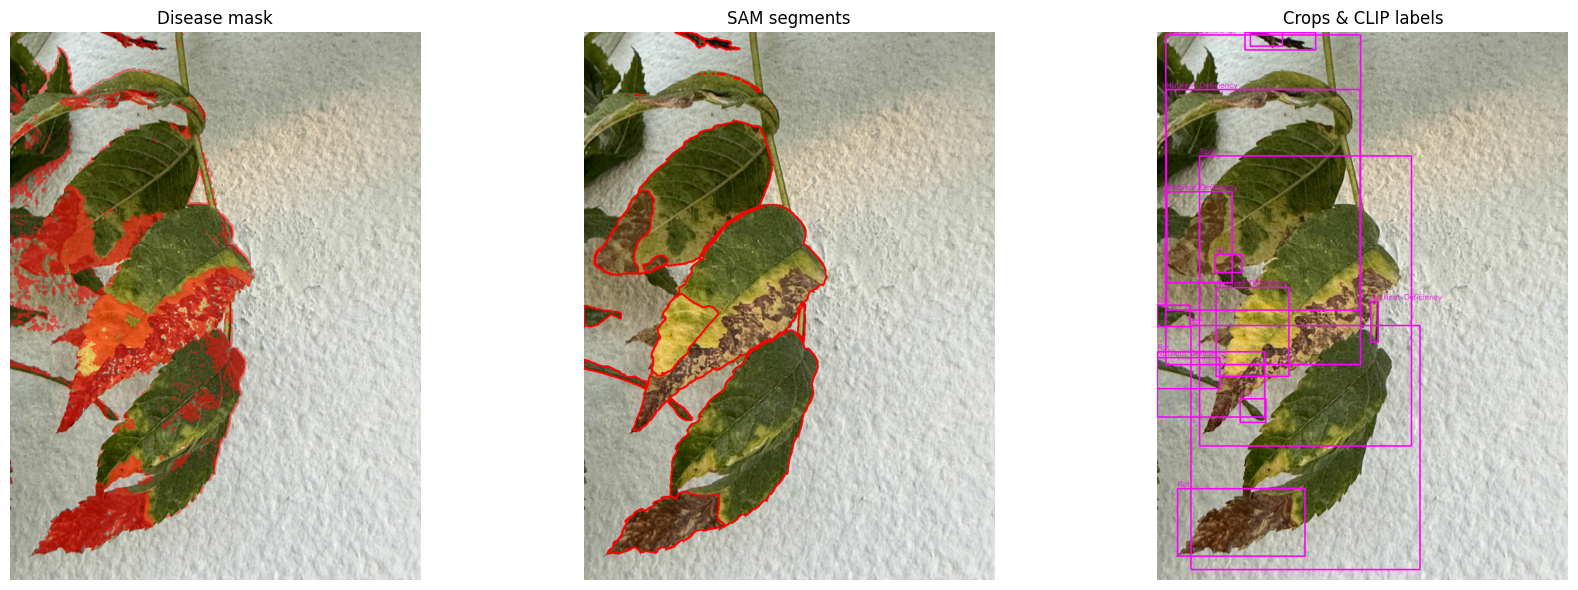

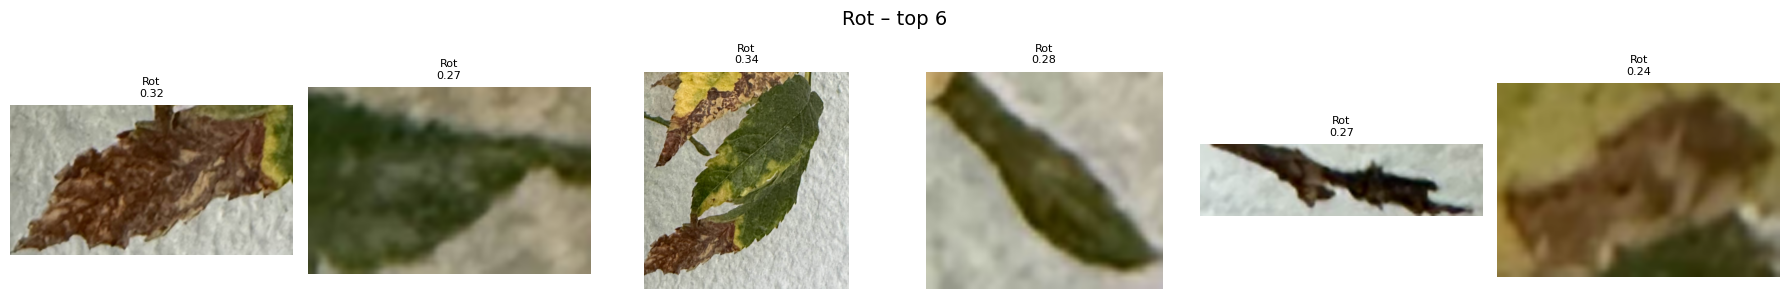

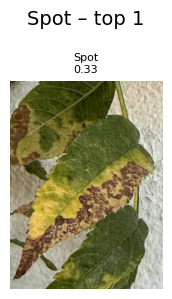

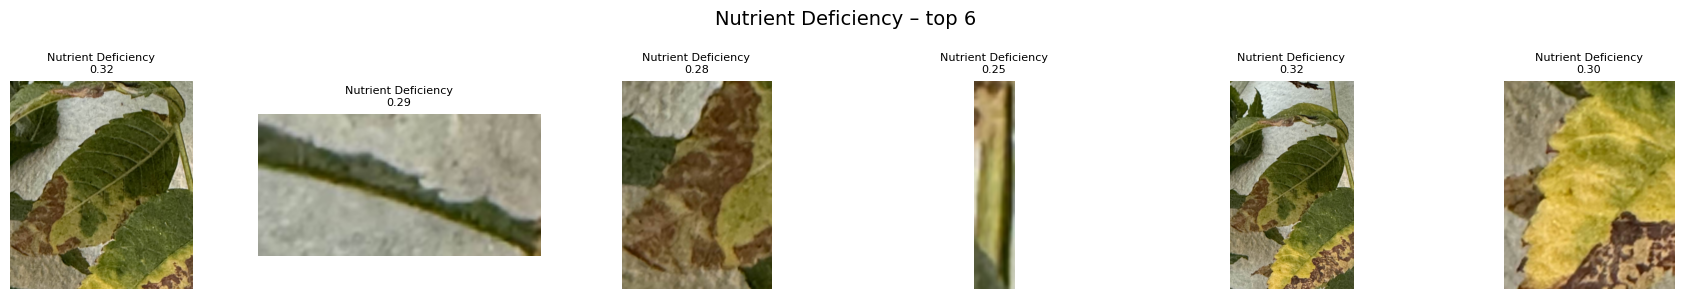

In [321]:
# ─── 8. VISUAL SUMMARY   ────────────────────────
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

overlay = image_rgb.copy()
overlay[disease_mask > 0] = (overlay[disease_mask > 0] * 0.5 + np.array([255,0,0])*0.5).astype(np.uint8)
axs[0].imshow(overlay); axs[0].set_title("Disease mask"); axs[0].axis("off")

vis = image_rgb.copy()
for res in filtered_sam_result:
    cnts, _ = cv2.findContours(res["segmentation"].astype(np.uint8), cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(vis, cnts, -1, (255, 0, 0), 2)
axs[1].imshow(vis); axs[1].set_title("SAM segments"); axs[1].axis("off")

final_vis = image_rgb.copy()
for cls, lst in selected.items():
    for e in lst:
        x1,y1,x2,y2 = map(int, e["bbox"])
        cv2.rectangle(final_vis, (x1, y1), (x2, y2), (255, 0, 255), 2)
        cv2.putText(final_vis, cls, (x1, max(0,y1-4)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 1)
axs[2].imshow(final_vis); axs[2].set_title("Crops & CLIP labels"); axs[2].axis("off")
plt.tight_layout(); plt.show()

for cls, lst in selected.items():
    if not lst: continue
    n = min(len(lst), TOP_K_VIZ)
    plt.figure(figsize=(3*n,3))
    for i in range(n):
        img = cv2.cvtColor(cv2.imread(str(OUT_DIR / lst[i]["fn"])), cv2.COLOR_BGR2RGB)
        plt.subplot(1,n,i+1); plt.imshow(img); plt.axis("off")
        plt.title(f"{cls}\n{lst[i]['score']:.2f}", fontsize=8)
    plt.suptitle(f"{cls} – top {n}", fontsize=14); plt.tight_layout(); plt.show()